In [ ]:
import os
import numpy as np

import tensorflow as tf
# import tensorflow.contrib.slim as slim
from mlxtend.data import loadlocal_mnist

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
cdd_n = 5
epoch = 55

sess = tf.Session()
saver = tf.train.import_meta_graph('/users/jmy/data/nets/16_class/VGG_Base/cdd_{}/net-{}.ckpt.meta'.format(str(cdd_n).zfill(2),str(epoch)))
graph = tf.get_default_graph()
saver.restore(sess, '/users/jmy/data/nets/16_class/VGG_Base/cdd_{}/net-{}.ckpt'.format(str(cdd_n).zfill(2),str(epoch)))

x = graph.get_tensor_by_name("Placeholder:0")
y = graph.get_tensor_by_name("Placeholder_1:0")
is_training = graph.get_tensor_by_name("Placeholder_2:0")

In [ ]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))

# val img load
pth = '/users/jmy/data/image_sound/imagenet/val_9550.npz'
l = np.load(pth)
tmp = l['imgnet_val'].reshape(9550,224,224,3).astype(np.float32) # imgnet_val_lb
imgnet_val = np.zeros((tmp.shape),dtype=np.float32)
for i_, img_ in enumerate(tmp):
    new = img_ - vgg_mean
    imgnet_val[i_] = new[:,:,::-1]
# mnst
pth = '/users/jmy/data/image_sound/imagenet/mnst_224_int8.npz'
l = np.load(pth)
#mnst_trn = l['mnst_trn']
tmp = l['mnst_val'].reshape(10000,224,224,3).astype(np.float32)
mnst_val = np.zeros((tmp.shape),dtype=np.float32)
for i_, img_ in enumerate(tmp):
    new = img_ - vgg_mean
    mnst_val[i_] = new[:,:,::-1]

_, mv_lb = loadlocal_mnist(
    images_path='/data/01_experiment_data/image_sound/mnist/raw/t10k-images-idx3-ubyte', 
    labels_path='/data/01_experiment_data/image_sound/mnist/raw/t10k-labels-idx1-ubyte')
del _, l, tmp

# mnst
mnst_val_lb = np.zeros((10000,16),dtype=np.float32)
for i,v in enumerate(mv_lb):
    mnst_val_lb[i,v] = 1

# imgnet
imgnet_val_lb = np.zeros((9550,16), dtype=np.float32)
imgnet_val_lb[:150,10] = 1
imgnet_val_lb[150:2950,11] = 1
imgnet_val_lb[2950:3200,12] = 1
imgnet_val_lb[3200:9150,13] = 1
imgnet_val_lb[9150:9300,14] = 1
imgnet_val_lb[9300:,15] = 1

In [ ]:
x_val = np.zeros((19550,224,224,3),dtype=np.float32)
x_val[:10000], x_val[10000:] = mnst_val, imgnet_val
y_val = np.zeros((19550,16),dtype=np.float32)
y_val[:10000], y_val[10000:] = mnst_val_lb, imgnet_val_lb

In [ ]:
batch_val = 256
nval = x_val.shape[0]
tot_batch = int(nval/batch_val)+1 # 76+1
pred = tf.argmax(graph.get_tensor_by_name('SpatialSqueeze:0'),1)
pred_list = []

for i in range(tot_batch): 
    batch_xs = x_val[i*batch_val:min((i+1)*batch_val, nval), :]
    batch_ys = y_val[i*batch_val:min((i+1)*batch_val, nval)]
    feeds = {x: batch_xs, y: batch_ys, is_training:False}
    pred_list.append(sess.run(pred,feed_dict=feeds))

In [ ]:
pred_list_2 = []
for i in range(len(pred_list)):
    for v in pred_list[i]:
        pred_list_2.append(v)

In [ ]:
val_label = np.zeros((19550))
val_label[:10000] = np.argmax(mnst_val_lb,axis=1)
val_label[10000:] = np.argmax(imgnet_val_lb,axis=1)

In [ ]:
pred_arr = np.array(pred_list_2)

In [ ]:
import pandas as pd
import seaborn as sns
label_list = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
                'eight', 'nine', 'bed', 'bird', 'cat', 'dog', 'house', 'tree']

In [ ]:
for vi in range(16):
    strtmp = label_list[vi]
    label_list[vi] = strtmp[0].upper() + strtmp[1:]

In [ ]:
conf = pd.crosstab(val_label, pred_arr, rownames=['True'], colnames=['Predicted']).apply(lambda r: r/r.sum(), axis=1)
corr_df = conf * 100

In [ ]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask, 1)] = True

In [ ]:
import math
annot = corr_df.values
annot = annot.flatten()
for vi , v in enumerate(annot):
    annot[vi] = math.floor(v*10)/10
annot = annot.reshape(16,16).astype('str')
annot[annot == "0.0"] = ""
annot[0, 0] = "100"

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [ ]:
import matplotlib as mpl
org_cmap = plt.get_cmap("RdYlBu")
vmin = 50  # minimum value to show on colobar
vmax = 100 # maximum value to show on colobar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#generate colors from original colormap in the range equivalent to [vmin, vamx] 
colors = org_cmap(np.linspace(1. - (vmax - vmin) / float(vmax), 1, cmap.N))
# Create a new colormap from those colors
new_cmap = mpl.colors.LinearSegmentedColormap.from_list('cut_jet', colors)

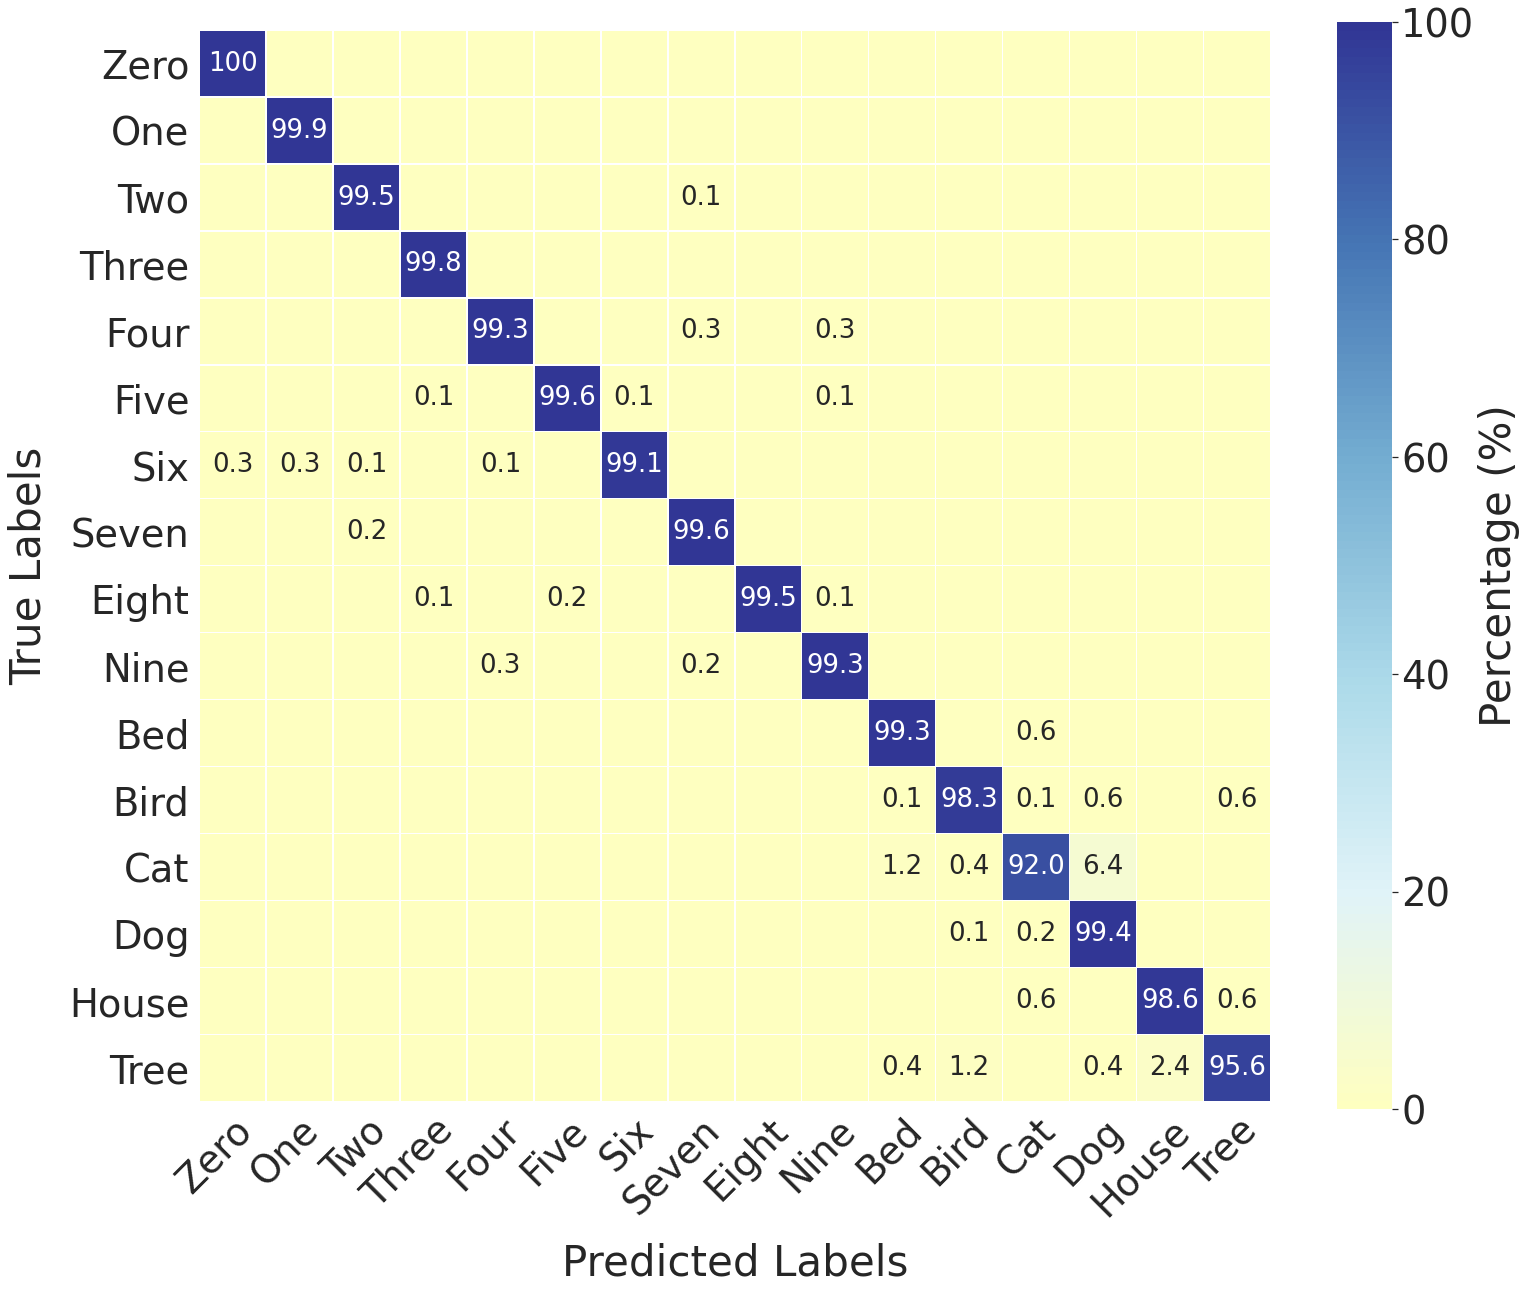

In [39]:
sns.set(style="white", font_scale=3.5)
fig, ax =plt.subplots(figsize=(24, 20))
sns.heatmap(
    corr_df, 
    cmap=new_cmap,
    vmax=100,
    vmin=0,
    # mask=mask,
    xticklabels=label_list,
    yticklabels=label_list,
    linewidths=.5,
    annot=annot,
    fmt="",
    square=True,
    annot_kws={'size': 26},
    cbar_kws={"shrink": 1,
              "label": "Percentage (%)"},
    ax=ax
)
ax.set_xlabel("Predicted Labels", labelpad=20)
ax.set_ylabel("True Labels", labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()